In [13]:
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm


### Here I create my Lidar model.

-   To do this I use Pytorch's modules like: nn.Module(), nn.Sequential(), nn.Linear(), etc.
-   To start, I create the class LidarBrain with nn.Module between the ().
-   Then I define my model, I decided to use nn.Linear() since this is a regression problem.
-   I use nn.Sequential() to define the amount of layers and so that I'm able to change the activation function per layer.
-   After some experimentation I've found that using the activation function nn.ReLU() worked best. 

In [4]:
class LidarBrain(nn.Module):
    
    def __init__(self, inputs_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, outputs_size):
        super().__init__()

        self.lb_model = nn.Sequential(
            nn.Linear(inputs_size, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.ReLU(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.ReLU(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.ReLU(),
            nn.Linear(hidden5_size, outputs_size)
            # nn.ReLU(),
            # nn.Linear(hidden4_size, outputs_size)
        )

    def forward(self, x):

        return self.lb_model(x)

### Load in the data

-   I load in the data and assign X (scanner data) and Y (steering angle). I decided to leave out the target velocity as that would complicate things.
-   I also convert the data to a torch.Tensor(), this worked best after first converting it to a np.array.

In [40]:
load_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/data/data_3rounds"

data_file = pd.read_table(load_path, sep = ",", index_col = 0)


# Create X data and Y data by converting them to torch.tensor
X = torch.Tensor(np.array(data_file.iloc[:, :-2], copy=False))

# We decided to leave out the velocity for now.
Y = torch.Tensor(np.array(data_file.iloc[:, 16:17], copy=False))

print(X)
print(Y[0].type())
print(data_file.head())

tensor([[ 7.4593,  6.8660,  8.4048,  ...,  4.3179,  5.5356,  1.4650],
        [ 7.4592,  6.8659,  8.4047,  ...,  4.3179,  5.5356,  1.4650],
        [ 7.4592,  6.8659,  8.4047,  ...,  4.3179,  5.5356,  1.4650],
        ...,
        [ 7.1591,  3.1682,  1.1354,  ...,  1.1064, 20.0000, 20.0000],
        [ 7.1591,  3.1682,  1.1354,  ...,  1.1064, 20.0000, 20.0000],
        [ 7.1591,  3.1682,  1.1354,  ...,  1.1064, 20.0000, 20.0000]])
torch.FloatTensor
        0       1       2        3        4        5       6       7        8  \
0  7.4593  6.8660  8.4048  10.2781  12.9475   9.7540  5.7571  5.8859   3.9555   
1  7.4592  6.8659  8.4047  10.2780  12.9474   9.7540  5.7570  5.8859   3.9554   
2  7.4592  6.8659  8.4047  10.2780  12.9474   9.7540  5.7570  5.8859   3.9554   
3  7.4566  6.8634  8.4025  10.2759  12.9456  11.2519  5.7557  5.8850  20.0000   
4  7.4507  6.8577  8.3973  10.2711  12.9414  11.2484  5.7526  5.8828  20.0000   

      9    10      11      12      13      14      15    16  

### Time to train the model!

-   During this project I've experimented with a lot of different settings (more about this after saving the model).
-   I start by defining the epochs and learning rate

LidarBrain(
  (lb_model): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
)


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]

[176.78324256881805, 135.26204999919915, 112.43422843826932, 104.83988990935369, 99.65220602274415, 92.70532748903005, 88.63907464455895, 84.01578883290527, 80.37517210124264, 77.33830916668265, 72.60692743657835, 69.91977537507802, 66.40085769410636, 63.07124558973976, 62.07516495418359, 57.24340389974075, 53.6690361874241, 50.65123705171923, 47.58529372338509, 45.770166114120784, 41.73892383120406, 41.003624881001166, 36.92123206377504, 34.11451816701036, 32.20726184010743, 30.117168453057293, 27.64299259887301, 25.76615792998737, 23.106504102350467, 22.341498140312332, 20.464732206839454, 19.622864491896884, 19.206771779012964, 17.384243665585224, 15.429368744313598, 15.888490572127386, 13.892861331907465, 14.03876950418499, 12.620276655520406, 12.59680094159621, 10.338974732290916, 10.175920820378405, 9.598773281569509, 8.839587873895884, 9.133685599501517, 8.366133800083789, 8.688579386081658, 7.790283092447588, 7.777527606155479, 6.757878947210596, 6.528421777972644, 6.0944787498

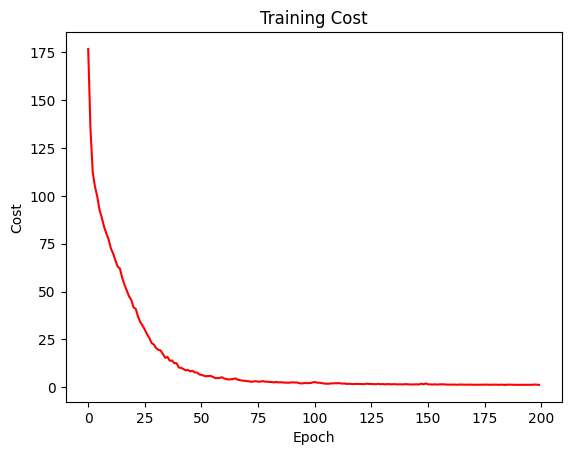

In [41]:
# Define epochs and learning rate.
epochs = 200
learningRate = 0.000095

# Define model and amount of neurons per layer.
lb = LidarBrain(len(X[0]), 128, 128, 128, 128, 128, len(Y[0]))
print(lb)

# Create empty list for losses
losses = []

# Take binary cross entropy as loss function (one output interpreted as binary)
lossFunction = nn.MSELoss()

# Use stochastic gradient descent as optimizer, use weights and biases of model
gradientDescent = torch.optim.SGD(lb.parameters(), lr=learningRate)

# Add a loader for faster calculation and being able to use the shuffle=True function (which makes it less likely the model will just remember the track in order).
loader = DataLoader(list(zip(X, Y)), shuffle=True, batch_size=10)

# Train. I'm making use of the tqdm() library to keep track while it's buisy
for i in tqdm(range(epochs)):

    # Create empty losses_epoch list so I can .append() per epoch.
    losses_epoch = []

    for x, y in loader:
    
        # Reset the gradient delta's
        gradientDescent.zero_grad()

        # Forward step
        yhat = lb(x)

        # Compute loss
        loss = lossFunction(yhat, y)
        
        # Keep track of loss
        losses_epoch.append(loss.item())

        # Apply gradient descent (via backpropagation)
        loss.backward()

        # Use w += -step * dw * learnRate
        gradientDescent.step()

    # Append losses per epoch
    losses.append(sum(losses_epoch)/len(losses_epoch))

print(losses)

# Plot the losses (cost) vs the amount of epochs
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(len(losses))], losses, 'red')
plt.show()

### save the model.

-   Use pickle to save the model.
-   To experiment and try different epochs/learningrate/hidden-layers etc. I just returned to this notebook every time and saved it again to overwrite the model before or to a new name if I wanted to keep the old model.

In [42]:
save_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/pickle/LidarBrain.pkl"

pickle.dump(lb.lb_model, open(save_path, 'wb'))

## After trying lots and lots of different things my conclusion is that Lidar is to unstable on THIS track to function in a safe way.

Things I've tried:
- Different Epochs
- Different learning rates
- Different data sets
- Different batch sizes
- More/less hiddenlayers
- More/less neurons
- With/without activation function.
- Different max range on the scanner
- Change the data by applying the IQR method


### Now with Sonar

-   Since I did lidar first, all I had to do was do the exact same thing with sonar. As I set the input in my model as len(X) all I had to do was copy and paste the lidar version and change a few things so that it is it's own thing.

In [17]:
class SonarBrain(nn.Module):
    
    def __init__(self, inputs_size, hidden1_size, hidden2_size, outputs_size):
        super().__init__()

        self.sb_model = nn.Sequential(
            nn.Linear(inputs_size, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, outputs_size)
            # nn.ReLU(),
            # nn.Linear(hidden3_size, outputs_size)
            # nn.Linear(hidden2_size, hidden3_size),
            # nn.ReLU(),
            # nn.Linear(hidden3_size, hidden4_size),
            # nn.ReLU(),
            # nn.Linear(hidden4_size, outputs_size)
        )

    def forward(self, x):

        return self.sb_model(x)

In [6]:
load_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/data/sonar_data_3r"

data_file_2 = pd.read_table(load_path, sep = ",", index_col = 0)


# Create X data and Y data by converting them to torch.tensor
X_2 = torch.Tensor(np.array(data_file_2.iloc[:, :-2], copy=False))

# We decided to leave out the velocity for now.
Y_2 = torch.Tensor(np.array(data_file_2.iloc[:, 3:4], copy=False))

print(X_2)
print(Y_2)
print(data_file_2.head())

tensor([[1.4683, 1.2854, 1.7757],
        [1.4683, 1.2854, 1.7757],
        [1.4683, 1.2854, 1.7757],
        ...,
        [2.0547, 1.3089, 0.9240],
        [2.0547, 1.3089, 0.9240],
        [1.9351, 1.2385, 1.3189]])
tensor([[-22.],
        [-22.],
        [-22.],
        ...,
        [  0.],
        [  0.],
        [  0.]])
        0       1       2     3         4
0  1.4683  1.2854  1.7757 -22.0  1.133333
1  1.4683  1.2854  1.7757 -22.0  1.133333
2  1.4683  1.2854  1.7757 -22.0  1.133333
3  1.4683  1.2854  1.7757 -22.0  1.133333
4  1.4683  1.2854  1.7757 -22.0  1.133333


SonarBrain(
  (sb_model): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


100%|██████████| 100/100 [02:38<00:00,  1.59s/it]

[101.08351703035446, 93.30143506276922, 89.23353503242498, 84.68873217313359, 77.90589529687755, 69.52773143077076, 61.66650464771869, 56.26207986478088, 53.12651391835775, 50.9657149074031, 49.26622901599706, 47.80608882060305, 46.48572221798609, 45.22334813470034, 44.01777006966879, 42.80838579616256, 41.589000103468116, 40.36423455561029, 39.12238005304777, 37.83877802420151, 36.46819889456225, 35.04200163969711, 33.60746056988801, 32.1917443834692, 30.81732595724254, 29.471635648663643, 28.1835176196524, 26.936545367237777, 25.757819909324898, 24.630478621782295, 23.576431370868423, 22.599137016067665, 21.675457305317742, 20.81059915968459, 20.00476267175091, 19.25624018832883, 18.579553433708686, 17.973586533625554, 17.41536825352564, 16.907371767799855, 16.4544214105162, 16.03453662702508, 15.645007790311912, 15.283910681080371, 14.938122899191034, 14.60954850788991, 14.303298108865388, 14.006972863244048, 13.719673435246976, 13.44322148661446, 13.182532913672675, 12.927264620161

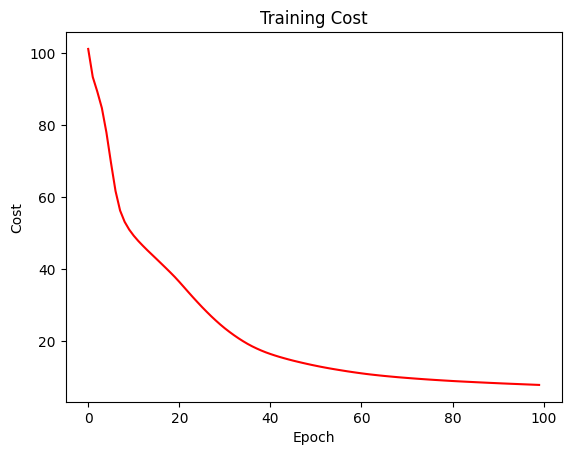

In [19]:
epochs_2 = 100

learningRate_2 = 0.00001

#----------------------------------------

sb = SonarBrain(len(X_2[0]), 64, 64, len(Y_2[0]))

print(sb)

#----------------------------------------

losses = []

# Take binary cross entropy as loss function (one output interpreted as binary)
lossFunction_2 = nn.MSELoss()

# Use stochastic gradient descent as optimizer, use weights and biases of model
gradientDescent_2 = torch.optim.SGD(sb.parameters(), lr=learningRate_2)

#----------------------------------------

for j in tqdm(range(epochs_2)):

    losses_epoch = []
    for x, y in zip(X_2, Y_2):
    
        # Reset the gradient delta's (dw, db)
        gradientDescent_2.zero_grad()

        # Forward step
        yhat = sb(x)

        # Compute loss
        loss = lossFunction_2(yhat, y)
        
        # Keep track of loss
        losses_epoch.append(loss.item())

        # Apply gradient descent (via backpropagation)
        loss.backward()

        # Use w += -step * dw * learnRate
        gradientDescent_2.step()

    losses.append(sum(losses_epoch)/len(losses_epoch))

print(losses)

#----------------------------------------

fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(len(losses))], losses, 'red')
plt.show()

#----------------------------------------

In [20]:
save_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/pickle/SonarBrain.pkl"

pickle.dump(sb.sb_model, open(save_path, 'wb'))

# Conclusion

-   Experimenting with both Lidar and Sonar i've found that Lidar is very unstable compared to Sonar, my sonar model worked almost perfectly after 2 different training sessions while I've worked for almost a whole week to try and make the Lidar version more stable.

-   After testing the hardcoded Lidar version some more I found out that after a couple of rounds it also straightup runs off the track. This means I've been training my Lidar model with unstable data to begin with and it won't ever be stable using this type of machinelearning.